In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [33]:
sample = 'HG00621_1'
sample_1 = sample.split('_')[0]
assemblies = ['afr', 'hg38', 't2t']
meta = load_meta()
pop = meta.loc[meta['sample'] == sample_1, 'population'].values[0]
c_dict, _ = get_population_colors()
color = c_dict[pop]

thresh = 0


In [41]:
files = expand(proc_cfg(config['lr']['map']['bam_mapqs'], od),
                          sample=sample,
                          assembly=assemblies)

In [42]:
i = 0
for f, a in zip(files, assemblies):
    temp = pd.read_csv(f, sep='\t')
    temp.rename({'mapq':a}, axis=1, inplace=True)
    assert len(temp.index) == len(temp.read_id.unique())
    
    if i == 0:
        df = temp.copy(deep=True)
    else:
        df = df.merge(temp, how='outer', on='read_id')
    i += 1

# convert to binary
df.fillna(0, inplace=True)
df.set_index('read_id', inplace=True)
df = df>thresh

df.reset_index(inplace=True)
df.set_index(assemblies, inplace=True)

In [43]:
df.head()

read_id
afr  hg38 t2t                                           
True True True    f87d20ec-f864-44d5-9a24-a7366cd0f9ad:0
          True    5881373b-81a1-42a0-8555-9ac336dae87d:0
          True  6836a82f-88a6-42ba-b52f-f877d3e578da:0_1
          True    f540d9cd-e5cd-4183-bcee-4b78b8aa24ff:0
          True    2357c9be-1000-4835-9bdf-30b0389218e6:0

## which reads map (binary; mapq>0)

In [35]:

# t2t_file = proc_cfg(expand(config['lr']['map']['bam_mapqs'],
#                           sample=sample,
#                           assembly='t2t')[0], od)
# hg38_file = proc_cfg(expand(config['lr']['map']['bam_mapqs'],
#                           sample=sample,
#                           assembly='hg38')[0], od)
# afr_file = proc_cfg(expand(config['lr']['map']['bam_mapqs'],
#                           sample=sample,
#                           assembly='afr')[0], od)

# df = pd.read_csv(hg38_file, sep='\t')
# df.rename({'mapq':'hg38'}, axis=1, inplace=True)
# assert len(df.index) == len(df.read_id.unique())

# df2 = pd.read_csv(t2t_file, sep='\t')
# df2.rename({'mapq':'t2t'}, axis=1, inplace=True)
# assert len(df2.index) == len(df2.read_id.unique())

# df3 = pd.read_csv(afr_file, sep='\t')
# df3.rename({'mapq':'afr'}, axis=1, inplace=True)
# assert len(df3.index) == len(df3.read_id.unique())

# df = df.merge(df2, how='outer', on='read_id')
# df = df.merge(df3, how='outer', on='read_id')

# # convert to binary
# df.fillna(0, inplace=True)
# df.set_index('read_id', inplace=True)
# df = df>thresh

# df.reset_index(inplace=True)
# df.set_index(['hg38', 't2t', 'afr'], inplace=True)

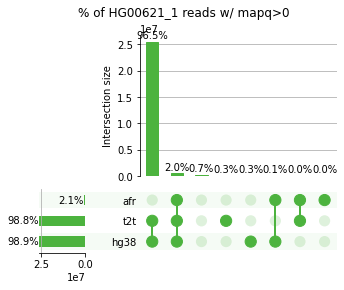

In [44]:
ax_dict = upsetplot.UpSet(df, subset_size='count',
                          facecolor=color,
                          sort_by='cardinality',
                          show_counts=False,
                          show_percentages=True).plot()
fname = f'{sample}_mapq_{thresh}_binary_upset.pdf'
plt.suptitle(f'% of {sample} reads w/ mapq>{thresh}')
plt.savefig(fname, dpi=500)

In [30]:
# TODO save IDs of reads that uniquely map to afr contigs
afr_reads = df.copy(deep=True)
afr_reads.reset_index(inplace=True)
afr_reads = afr_reads.loc[(afr_reads.afr==True)&\
                          (afr_reads.t2t==False)&\
                          (afr_reads.hg38==False)]
afr_reads = afr_reads[['read_id']]
afr_reads.to_csv(f'{sample}_afr_reads.txt', index=False)

In [23]:
df['total_reads'] = df.n_reads.sum()
df['perc'] = (df.n_reads/df.total_reads)*100
df['sample'] = sample
df.head()

,afr,hg38,t2t,n_reads,total_reads,perc,sample
0,False,False,False,184707,26336522,0.701334,HG00621_1
1,False,False,True,89342,26336522,0.339232,HG00621_1
2,False,True,False,87922,26336522,0.333841,HG00621_1
3,False,True,True,25419910,26336522,96.519616,HG00621_1
4,True,False,False,6601,26336522,0.025064,HG00621_1


In [ ]:
fname = f'